# A/B Testing Analysis

This notebook analyzes the results of an A/B test comparing two landing pages (old vs. new) to determine if the new page improves user conversion rates. The dataset contains user interactions, including whether they converted (e.g., made a purchase or signed up) after visiting either the control (old_page) or treatment (new_page) landing page. The analysis includes data cleaning, exploratory data analysis, hypothesis testing, and confidence interval estimation to draw statistically sound conclusions.

### Sections:
- Data Loading and Initial Exploration
- Data Cleaning
- Exploratory Data Analysis
- Hypothesis Testing
- Confidence Intervals
- Conclusion and Recommendations

# Load and inspect the data

In [1]:
import pandas as pd
df = pd.read_csv("C:/Users/amro6/Downloads/ab_data.csv")

# Quick look at the data
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [3]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [4]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

# Verify Consistency Between Group and Landing Page

Ensure that users in the `control` group saw the `old_page` and users in the `treatment` group saw the `new_page`. Mismatches between `group` and `landing_page` could indicate data collection errors, which would skew the analysis. We check for inconsistencies and quantify the number of mismatched rows.

In [5]:
# Check for mismatches
df[((df['group'] == 'treatment') & (df['landing_page'] != 'new_page')) |
   ((df['group'] == 'control') & (df['landing_page'] != 'old_page'))].shape

(3893, 5)

# Remove those mismatches:

In [6]:
# Keep only rows with consistent group/landing_page pairs
df2 = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) |
         ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))]

# Check Group Balance

Verify that the control and treatment groups have similar sample sizes to ensure a fair comparison in the A/B test. Imbalanced groups could bias the results of the hypothesis test.

In [10]:
print(df2['group'].value_counts())

group
treatment    145311
control      145274
Name: count, dtype: int64


# Remove duplicate user_ids

In [11]:
# Check for duplicate users
df2['user_id'].duplicated().sum()

1

In [12]:
# Drop duplicate user_ids
df2 = df2.drop_duplicates(subset='user_id')

### Visualize Conversion Counts by Group

Create a count plot to compare the number of conversions (1) and non-conversions (0) between the control and treatment groups. This visualization helps assess the distribution of outcomes and provides a preliminary view of potential differences.

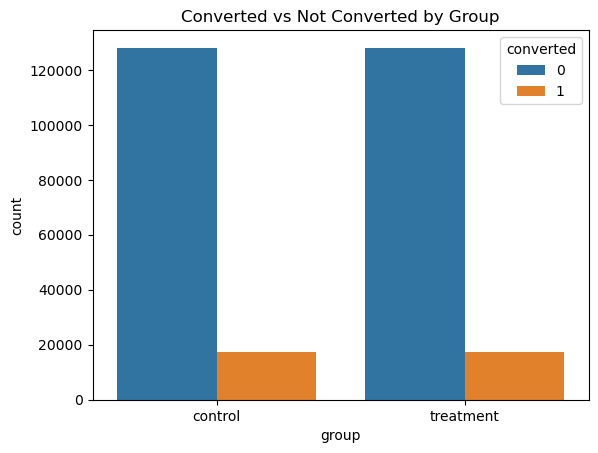

In [14]:
# Visualize conversion counts by group
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='group', hue='converted', data=df2)
plt.title("Converted vs Not Converted by Group")
plt.show()

# Calculate Conversion Rates

Compute the proportion of users who converted (`converted = 1`) in each group to compare the performance of the old and new landing pages.

In [13]:
conversion_rates = df2.groupby('group')['converted'].mean()
print(conversion_rates)

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64


## Hypothesis Testing: Proportions Z-Test

Perform a two-sample proportions z-test to compare the conversion rates between the control and treatment groups. The null hypothesis (H₀) assumes no difference in conversion rates between the old and new pages, while the alternative hypothesis (H₁) assumes a difference exists. A p-value < 0.05 would indicate statistical significance at the 5% level.

In [14]:
from statsmodels.stats.proportion import proportions_ztest

# number of conversions
convert_control = df2[df2['group'] == 'control']['converted'].sum()
convert_treatment = df2[df2['group'] == 'treatment']['converted'].sum()

# number of users
n_control = df2[df2['group'] == 'control'].shape[0]
n_treatment = df2[df2['group'] == 'treatment'].shape[0]

# successes and observations
successes = [convert_control, convert_treatment]
nobs = [n_control, n_treatment]

# run z-test
z_score, p_value = proportions_ztest(successes, nobs)
print(f"z-score: {z_score:.4f}")
print(f"p-value: {p_value:.4f}")

z-score: 1.3109
p-value: 0.1899


# Confidence Interval for Conversion Rate Difference

Calculate a 95% confidence interval for the difference in conversion rates between the treatment and control groups to quantify the range of plausible differences and assess practical significance.

In [16]:
import numpy as np

# conversion rates
cr_control = convert_control / n_control
cr_treatment = convert_treatment / n_treatment

# difference in conversion rates
diff = cr_treatment - cr_control

# standard error
se_diff = np.sqrt(
    (cr_control * (1 - cr_control)) / n_control +
    (cr_treatment * (1 - cr_treatment)) / n_treatment
)

# 95% confidence interval
z_critical = 1.96  # for 95% confidence
ci_lower = diff - z_critical * se_diff
ci_upper = diff + z_critical * se_diff

print(f"Conversion rate difference: {diff:.4f}")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

Conversion rate difference: -0.0016
95% confidence interval: [-0.0039, 0.0008]


## Conclusion and Recommendations

After analyzing the A/B test data, we found no statistically significant difference in conversion rates between the control group (`old_page`) and the treatment group (`new_page`) at a 5% significance level (α = 0.05).

| Group     | Sample Size | Conversion Rate | Difference | 95% CI           | P-value |
|-----------|-------------|-----------------|------------|------------------|---------|
| Control   | 145,274     | 12.04%          | -0.16%     | [-0.39%, 0.08%] | 0.1899  |
| Treatment | 145,311     | 11.88%          |            |                  |         |

**Key Findings**:
- **Conversion Rates**: Control group: 12.04%, Treatment group: 11.88%.
- **Difference**: -0.16% (slightly lower for the new page).
- **95% Confidence Interval**: [-0.39%, 0.08%], which includes zero, indicating no significant difference.
- **P-value**: 0.1899, well above 0.05, failing to reject the null hypothesis.

**Recommendations**:
- Retain the current (`old_page`) landing page, as the new page does not demonstrate improved conversion rates.
- Consider extending the test duration to collect more data, which may increase statistical power.
- Explore alternative landing page designs or features that could have a stronger impact on conversions.
- Analyze user subgroups (e.g., by demographics or behavior) to identify any segment-specific effects.